In [55]:
import json
import os
from collections import defaultdict

import pandas as pd
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
from matplotlib import patches
from torch.utils.data import random_split, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATASET = os.path.join(".", "dataset")

In [3]:
labels = [name for name in os.listdir(PATH_TO_DATASET) 
          if os.path.isdir(os.path.join(PATH_TO_DATASET, name))]
labels

['Araneae',
 'Coleoptera',
 'Diptera',
 'Hemiptera',
 'Hymenoptera',
 'Lepidoptera',
 'Odonata']

In [21]:
len(labels)

7

In [22]:
labels_by_idx = {i + 1: v for i, v in enumerate(labels)}
labels_by_idx

{1: 'Araneae',
 2: 'Coleoptera',
 3: 'Diptera',
 4: 'Hemiptera',
 5: 'Hymenoptera',
 6: 'Lepidoptera',
 7: 'Odonata'}

In [23]:
label_idx_by_value = {v: i for i, v in labels_by_idx.items()}
label_idx_by_value

{'Araneae': 1,
 'Coleoptera': 2,
 'Diptera': 3,
 'Hemiptera': 4,
 'Hymenoptera': 5,
 'Lepidoptera': 6,
 'Odonata': 7}

In [5]:
labels_annotations = []

for label in labels:
    cur_label_annotations = []
    
    label_folder = os.path.join(PATH_TO_DATASET, label)
    annotations_folder = os.path.join(label_folder, "annotations")
    
    for ann_file in tqdm(os.listdir(annotations_folder)):
        if ann_file.lower().endswith(".json"):
            with open(os.path.join(annotations_folder, ann_file)) as f:
                ann = json.load(f)
                cur_label_annotations.append(ann)
            
    labels_annotations.append(cur_label_annotations)

100%|██████████| 2278/2278 [00:22<00:00, 102.71it/s]


In [6]:
print(f"Dataset samples count: {sum([len(la) for la in labels_annotations])}")

Dataset samples count: 15376


In [7]:
labels_annotations[0][0]

{'asset': {'format': 'jpg',
  'id': '0015753ccdad6bf8031175da605d0f6f',
  'name': '4679235f3408.jpg',
  'path': 'file:F:/ArTaxOr/Araneae/4679235f3408.jpg',
  'size': {'width': 3106, 'height': 2071},
  'state': 2,
  'type': 1},
 'regions': [{'id': 'oh6LxDplL',
   'type': 'RECTANGLE',
   'tags': ['Diptera', '_occluded'],
   'boundingBox': {'height': 950.9038262668047,
    'width': 849.8152997932461,
    'left': 997.5161957270849,
    'top': 530.6000517063082},
   'points': [{'x': 997.5161957270849, 'y': 530.6000517063082},
    {'x': 1847.331495520331, 'y': 530.6000517063082},
    {'x': 1847.331495520331, 'y': 1481.5038779731128},
    {'x': 997.5161957270849, 'y': 1481.5038779731128}]},
  {'id': 'RUY-blCG-',
   'type': 'RECTANGLE',
   'tags': ['Araneae'],
   'boundingBox': {'height': 878.086866597725,
    'width': 1093.842866988284,
    'left': 1205.1536871123365,
    'top': 389.24948293691835},
   'points': [{'x': 1205.1536871123365, 'y': 389.24948293691835},
    {'x': 2298.9965541006204

In [35]:
image_infos = []

for i, label in enumerate(labels):
    for ann in tqdm(labels_annotations[i]):
        image_regions = []
        for r in ann["regions"]:
            label = next(filter(lambda x: x in labels, r["tags"]))
            bounding_box = [
                r["boundingBox"]["left"],
                r["boundingBox"]["top"],
                r["boundingBox"]["left"] + r["boundingBox"]["width"],
                r["boundingBox"]["top"] + r["boundingBox"]["height"]
            ]
            region_info = {
                "label": label,
                "encoded_label": label_idx_by_value[label],
                "x_min": r["boundingBox"]["left"],
                "y_min": r["boundingBox"]["top"],
                "x_max": r["boundingBox"]["left"] + r["boundingBox"]["width"],
                "y_max": r["boundingBox"]["top"] + r["boundingBox"]["height"],
                "bounding_box": bounding_box
            }
            image_regions.append(region_info)
        
        image_info = {
            "image_name": ann["asset"]["name"],
            "folder": label,
            "image_width": ann["asset"]["size"]["width"],
            "image_height": ann["asset"]["size"]["height"],
            "regions": image_regions,
            "path_to_image": os.path.join(PATH_TO_DATASET, label, ann["asset"]["name"]),
        }
        
        image_infos.append(image_info)

100%|██████████| 2277/2277 [00:00<00:00, 168971.36it/s]


In [36]:
image_infos[0]

{'image_name': '4679235f3408.jpg',
 'folder': 'Araneae',
 'image_width': 3106,
 'image_height': 2071,
 'regions': [{'label': 'Diptera',
   'encoded_label': 3,
   'x_min': 997.5161957270849,
   'y_min': 530.6000517063082,
   'x_max': 1847.331495520331,
   'y_max': 1481.503877973113,
   'bounding_box': [997.5161957270849,
    530.6000517063082,
    1847.331495520331,
    1481.503877973113]},
  {'label': 'Araneae',
   'encoded_label': 1,
   'x_min': 1205.1536871123365,
   'y_min': 389.24948293691835,
   'x_max': 2298.9965541006204,
   'y_max': 1267.3363495346434,
   'bounding_box': [1205.1536871123365,
    389.24948293691835,
    2298.9965541006204,
    1267.3363495346434]}],
 'path_to_image': '.\\dataset\\Araneae\\4679235f3408.jpg'}

In [28]:
def show_sample(sample_data):
    img = plt.imread(sample_data["path_to_image"])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(img)
    ax.set_title(sample_data["folder"])
    
    for region in sample_data["regions"]:
        x_min = region["x_min"]
        y_min = region["y_min"]
        width = region["x_max"] - region["x_min"]
        height = region["y_max"] - region["y_min"]
    
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, region["label"], color='yellow', fontsize=12, weight='bold')
    
    plt.axis('off')
    plt.show()

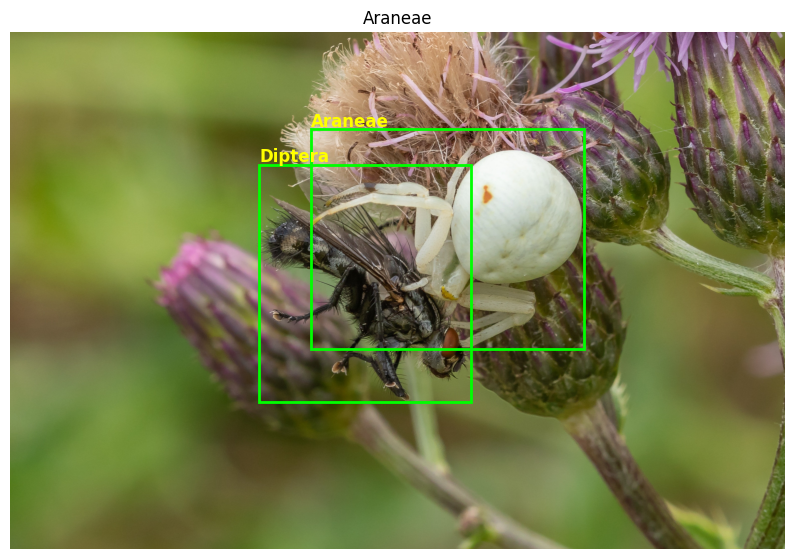

In [29]:
show_sample(image_infos[0])

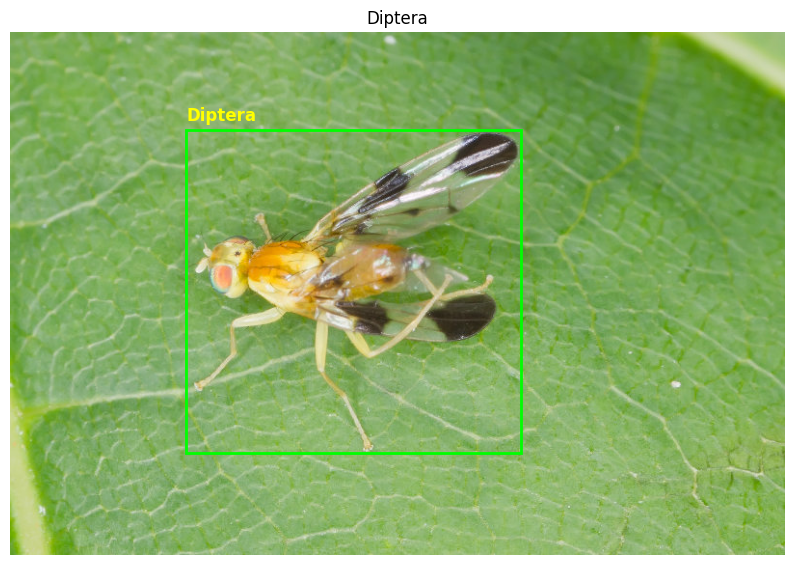

In [30]:
show_sample(image_infos[5000])

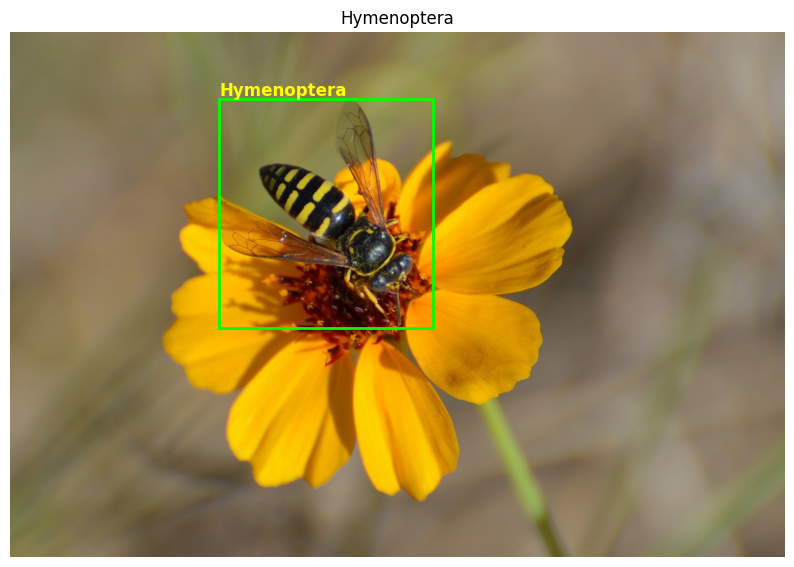

In [31]:
show_sample(image_infos[10000])

In [45]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_data, transforms=None):
        self.images_data = images_data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_data) 
    
    def __getitem__(self, idx):
        image_data = self.images_data[idx]
        
        image = Image.open(image_data["path_to_image"]).convert("RGB")
        boxes = []
        labels = []
        
        for r in image_data["regions"]:
            boxes.append(r["bounding_box"])
            labels.append(r["encoded_label"])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels
        }
        
        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)
            
        return image, target

In [46]:
BATCH_SIZE = 32

In [62]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [63]:
def split_dataset(images_annotations, val_fraction=0.2, test_fraction=0.1, random_state=42):
    annotations_by_folder = defaultdict(list)
    
    for ann in images_annotations:
        annotations_by_folder[ann["folder"]].append(ann)
    
    split_annotations = [annotations_by_folder[f] for f in labels if label in annotations_by_folder]
    
    train_dataloaders = []
    val_dataloaders = []
    test_annotations = []
    
    for folder_ann in split_annotations:
        len_test = int(len(folder_ann) * test_fraction)
        len_val = int((len(folder_ann) - len_test) * val_fraction)
        len_train = len(folder_ann) - len_test - len_val
        
        folder_dataset = CustomDataset(folder_ann)
        
        train_ds, val_ds, test_ds = random_split(
            folder_dataset, 
            [len_train, len_val, len_test],
            torch.Generator().manual_seed(random_state)
        )
        
        train_dataloaders.append(DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn))
        val_dataloaders.append(DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn))
        test_annotations.extend(test_ds.dataset.images_data)
        
    test_dataloader = DataLoader(test_annotations, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    return train_dataloaders, val_dataloaders, test_dataloader

In [64]:
train_dataloaders, val_dataloaders, test_dataloader = split_dataset(image_infos)

In [44]:
class CustomFasterRCNNDetector(torch.nn.Module):
    def __init__(self, n_classes):
        super(CustomFasterRCNNDetector, self).__init__()
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        )
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        
    def forward(self, x):
        return self.model(x) 